# Test variants of SLAV-seq L1 insertion classification model 

3/22/23

TODO: 
1. Try new features 
   - [ ] removing effect of sequencing depth (normalize by total reads)
   - [ ] add standard deviation of certain features?
   - [ ] try different window sizes
   - [ ] try removing flanking regionss

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyranges as pr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import StratifiedGroupKFold

## Define data reading functions

In [8]:
def read_rmsk(rmsk_outfile):
    """
    Read the repeatmasker output table and return locations of L1HS and L1PA2-6
    """
    # read the rmsk file
    df = pd.read_csv(
        rmsk_outfile,
        skiprows=3,
        delim_whitespace=True,
        names=["Chromosome", "Start", "End", "Strand", "repeat"],
        dtype={"Chromosome": str, "Start": int, "End": int},
        usecols=[4, 5, 6, 8, 9],
    )

    # filter for rep_names
    rep_names = [
        "L1HS_3end",
        "L1PA2_3end",
        "L1PA3_3end",
        "L1PA4_3end",
        "L1PA5_3end",
        "L1PA6_3end",
    ]

    df = df[df["repeat"].isin(rep_names)]

    # save to new dataframe
    df["Strand"] = df["Strand"].str.replace("C", "-")
    df["Start"] -= 1  # make zero-based

    # extend the repeats by 1000 bp
    df["Start"] = df.apply(
        lambda x: x["Start"] - 1000 if x["Strand"] == "-" else x["Start"], axis=1
    )
    df["End"] = df.apply(
        lambda x: x["End"] + 1000 if x["Strand"] == "+" else x["End"], axis=1
    )

    return df


def read_knrgl(knrgl_bedfile):
    df = pd.read_csv(
        knrgl_bedfile,
        sep="\t",
        header=None,
        names=["Chromosome", "Start", "End", "Strand"],
        dtype={"Chromosome": str, "Start": int, "End": int},
    )

    df["Start"] = df.apply(
        lambda x: x["Start"] - 1000 if x["Strand"] == "-" else x["Start"], axis=1
    )
    df["End"] = df.apply(
        lambda x: x["End"] + 1000 if x["Strand"] == "+" else x["End"], axis=1
    )

    return df

## Read in data

TODO: 
 - how many windows in the genome have reads? 
 - what fraction?

In [27]:
df = pd.read_parquet(
    "/iblm/netapp/data4/mcuoco/sz_slavseq/results/model/get_labels/CommonBrain.pqt"
)
# remove the low quality cell
df = df.loc[df["cell_id"] != "plate2_E7_S101"].reset_index(drop=True)

In [29]:
sv_blacklist = pr.read_bed("../../resources/sv_blacklist.bed").df
segdups = pr.read_bed("../../resources/segdups.bedpe").df

In [31]:
def label_windows(df: pd.DataFrame, other_df: pd.DataFrame, label: str):
    assert type(df) == pd.DataFrame, "df must be a pandas DataFrame"
    assert type(other_df) == pd.DataFrame, "other_df must be a pandas DataFrame"
    assert label not in df.columns, f"{label} already in df.columns"

    # convert to pyranges
    pr_df = pr.PyRanges(df)
    pr_other_df = pr.PyRanges(other_df)

    # get the windows that overlap with the other_df
    overlapping = pr_df.overlap(pr_other_df).df

    # set the index to the chromosome, start, and end
    # TODO: check if reads are in same orientation as repeats
    df.set_index(["Chromosome", "Start", "End"], inplace=True)
    overlapping.set_index(["Chromosome", "Start", "End"], inplace=True)

    # label the windows that overlap
    df[label] = df.index.isin(overlapping.index)

    # reset the index
    df.reset_index(inplace=True)

    return df

In [32]:
df = label_windows(df, sv_blacklist, "sv_blacklist")
df = label_windows(df, segdups, "segdups")

In [35]:
df["sv_blacklist"].value_counts()

False    59359434
True      1550034
Name: sv_blacklist, dtype: int64

In [40]:
df["segdups"].value_counts()

False    57114238
True      3795230
Name: segdups, dtype: int64

In [36]:
df["label"].value_counts()

FLANK    28877825
RMSK     24274985
OTHER     7698208
KNRGL       58450
Name: label, dtype: int64

In [41]:
df.loc[(df["label"] == "KNRGL") & (df["segdups"] == True), "label"].value_counts()

KNRGL    3323
Name: label, dtype: int64

In [42]:
df.loc[(df["label"] == "OTHER") & (df["segdups"] == True), "label"].value_counts()

OTHER    537174
Name: label, dtype: int64

In [43]:
df.loc[(df["label"] == "RMSK") & (df["segdups"] == True), "label"].value_counts()

RMSK    1377018
Name: label, dtype: int64

In [33]:
knrgl = read_knrgl(
    "/iblm/netapp/data4/mcuoco/sz_slavseq/resources/CommonBrain_insertions.bed"
)
rmsk = read_rmsk("/iblm/netapp/data4/mcuoco/sz_slavseq/resources/hs38d1.fa.out")

[None, Text(0, 0.5, 'Number of bins'), Text(0.5, 0, 'Label')]

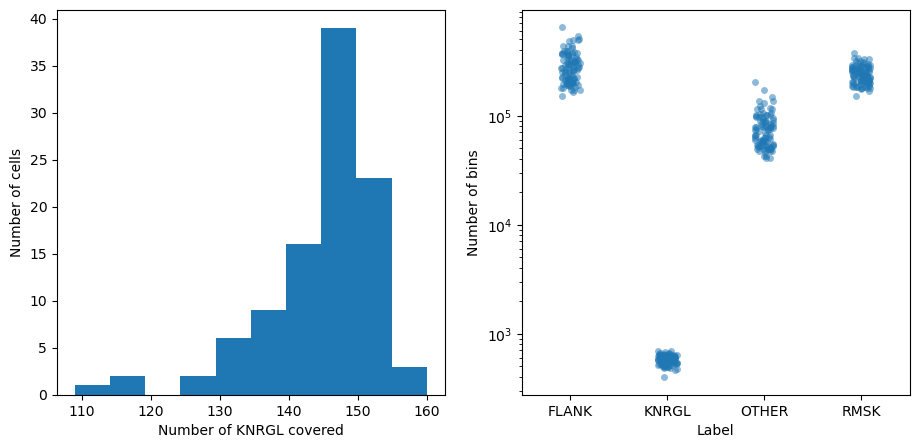

In [34]:
def knrgl_covered(df, knrgl):
    "compute number of knrgl covered by windows"

    # convert to pyranges
    pr_knrgl = pr.PyRanges(knrgl)
    pr_df = pr.PyRanges(df)

    # get the windows that overlap with the other_df
    overlapping = pr_knrgl.overlap(pr_df).df

    return len(overlapping)


# setup subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# 165 total germline
df.groupby(["cell_id"]).apply(lambda x: knrgl_covered(x, knrgl)).hist(ax=axes[0])
axes[0].set(xlabel="Number of KNRGL covered", ylabel="Number of cells")
axes[0].grid(False)

plot_df = (
    df.groupby(["cell_id", "label"]).size().reset_index().rename({0: "count"}, axis=1)
)
sns.stripplot(plot_df, x="label", y="count", alpha=0.5, ax=axes[1])
axes[1].set(yscale="log", ylabel="Number of bins", xlabel="Label")

In [44]:
# TODO: exclude window in background?
df.columns

Index(['Chromosome', 'Start', 'End', 'r2_fwd', 'r1_rev', 'YG_reads',
       'YA_reads', 'YS_reads', 'r1_fwd', 'r1_reads', 'r2_rev', 'r2_reads',
       'total_reads', 'frac_r1_fwd', 'r1_orientation_entropy', 'r1_mean_mapq',
       'r1_sd_mapq', 'r1_starts_gini', 'mean_template_length',
       'sd_template_length', 'YG_mean', 'YA_mean', 'YS_mean', 'YA_YG_ratio',
       'frac_r2_fwd', 'r2_orientation_entropy', 'r2_mean_mapq', 'r2_sd_mapq',
       'r2_starts_gini', 'r2_fwd_bg', 'r1_rev_bg', 'YG_reads_bg',
       'YA_reads_bg', 'YS_reads_bg', 'r1_fwd_bg', 'r1_reads_bg', 'r2_rev_bg',
       'r2_reads_bg', 'total_reads_bg', 'frac_r1_fwd_bg',
       'r1_orientation_entropy_bg', 'r1_mean_mapq_bg', 'r1_sd_mapq_bg',
       'r1_starts_gini_bg', 'mean_template_length_bg', 'sd_template_length_bg',
       'YG_mean_bg', 'YA_mean_bg', 'YS_mean_bg', 'YA_YG_ratio_bg',
       'frac_r2_fwd_bg', 'r2_orientation_entropy_bg', 'r2_mean_mapq_bg',
       'r2_sd_mapq_bg', 'r2_starts_gini_bg', 'cell_id', 'donor_id

In [46]:
# save all features for model to list
features = [
    x
    for x in df.columns
    if not any(
        x.endswith(y)
        for y in [
            "Chromosome",
            "Start",
            "End",
            "cell_id",
            "donor_id",
            "label",
            "index",
            "reads",
            "entropy",
            "fwd",
            "rev",
            "reads_bg",
            "entropy_bg",
            "fwd_bg",
            "rev_bg",
            "sv_blacklist",
            "segdups",
        ]
    )
]
# add back fractions
features.extend(["frac_r1_fwd", "frac_r2_fwd", "frac_r1_fwd_bg", "frac_r2_fwd_bg"])
assert all(x in df.columns for x in features), "some feature are not in the dataframe"
features

['r1_mean_mapq',
 'r1_sd_mapq',
 'r1_starts_gini',
 'mean_template_length',
 'sd_template_length',
 'YG_mean',
 'YA_mean',
 'YS_mean',
 'YA_YG_ratio',
 'r2_mean_mapq',
 'r2_sd_mapq',
 'r2_starts_gini',
 'r1_mean_mapq_bg',
 'r1_sd_mapq_bg',
 'r1_starts_gini_bg',
 'mean_template_length_bg',
 'sd_template_length_bg',
 'YG_mean_bg',
 'YA_mean_bg',
 'YS_mean_bg',
 'YA_YG_ratio_bg',
 'r2_mean_mapq_bg',
 'r2_sd_mapq_bg',
 'r2_starts_gini_bg',
 'frac_r1_fwd',
 'frac_r2_fwd',
 'frac_r1_fwd_bg',
 'frac_r2_fwd_bg']

## Define functions for data filtering, model training and testing

In [47]:
# define useful functions
def filter_data(df, bool_filter):
    label_counts = df["label"].value_counts().to_dict()
    knrgl_cov = df.groupby(["cell_id"]).apply(lambda x: knrgl_covered(x, knrgl))

    # remove other unwanted data
    df = df.loc[bool_filter, :].reset_index(drop=True)
    new_counts = df["label"].value_counts().to_dict()
    new_knrgl_cov = df.groupby(["cell_id"]).apply(lambda x: knrgl_covered(x, knrgl))

    for k in label_counts.keys():
        orig = label_counts[k]
        diff = label_counts[k] - new_counts[k]
        perc = diff / orig * 100
        print(f"removed {diff}/{orig} ({perc:.2f}%) {k} bins")

    knrgl_lost = sum(knrgl_cov - new_knrgl_cov)
    perc = knrgl_lost / sum(knrgl_cov) * 100
    print(f"lost {knrgl_lost}/{sum(knrgl_cov)} ({perc:.2f}%) covered knrgl")

    return df


def fit_evaluate(train, test, clf):

    # fit model on training set
    clf = clf.fit(train[features], train["label"])
    KNRGL_ind = np.where(clf.classes_ == "KNRGL")[0][0]

    # predict on test set
    proba = clf.predict_proba(test[features])

    # compute metrics
    # preicion-recall curve
    prc = pd.DataFrame()
    prc["precision"], prc["recall"], _ = precision_recall_curve(
        test["label"], proba[:, KNRGL_ind], pos_label="KNRGL"
    )
    prc["auc"] = auc(prc["recall"], prc["precision"])

    # receiver-operator characteristic curve
    roc = pd.DataFrame()
    roc["fpr"], roc["tpr"], _ = roc_curve(
        test["label"], proba[:, KNRGL_ind], pos_label="KNRGL"
    )
    roc["auc"] = auc(roc["fpr"], roc["tpr"])

    # feature importance
    fi = pd.DataFrame()
    fi["feature"] = clf.feature_names_in_
    fi["importance"] = clf.feature_importances_

    return prc, roc, fi


def plot_roc_prc(prc, roc, label, ax):
    ax[0].plot(
        prc["recall"],
        prc["precision"],
        label=f"{label}: AUC = {prc['auc'].values[0]:.3f}",
    )
    ax[0].set(
        xlim=(0, 1), ylim=(0, 1), xlabel="Recall", ylabel="Precision", title="PRC"
    )
    ax[0].axes.axline(xy1=(1, 0), slope=-1, linestyle="--", color="gray", linewidth=1)
    ax[0].set_aspect("equal", adjustable="box")
    ax[0].legend()
    ax[1].plot(
        roc["fpr"], roc["tpr"], label=f"{label}: AUC = {roc['auc'].values[0]:.3f}"
    )
    ax[1].set(
        xlim=(0, 1),
        ylim=(0, 1),
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC",
    )
    ax[1].axes.axline(xy1=(0, 0), slope=1, linestyle="--", color="gray", linewidth=1)
    ax[1].legend()
    ax[1].set_aspect("equal", adjustable="box")
    return ax

## Evaluate various pre-filtering strategies

Use basic RF model to evaluate the effect of different pre-filtering strategies

In [49]:
# create various filters
datas = dict()
min_r1_3 = (df["r1_fwd"] >= 3) | (df["r1_rev"] >= 3)
min_r1_5 = (df["r1_fwd"] >= 5) | (df["r1_rev"] >= 5)
high_ya_low_yg = (df["YA_mean"] > 20) & (df["YG_mean"] < 10)
noblacklist = ~df["sv_blacklist"] & ~df["segdups"]
# datas["high_ya_low_yg"] = high_ya_low_yg
datas["min_r1_3"] = high_ya_low_yg & min_r1_3
datas["min_r1_3_noblacklist"] = high_ya_low_yg & min_r1_3 & noblacklist
datas["min_r1_5"] = high_ya_low_yg & min_r1_5
datas["min_r1_5_noblacklist"] = high_ya_low_yg & min_r1_5 & noblacklist


processesing min_r1_3...
filtering data...
removed 26867408/28877825 (93.04%) FLANK bins
removed 23235494/24274985 (95.72%) RMSK bins
removed 7516221/7698208 (97.64%) OTHER bins
removed 15068/58450 (25.78%) KNRGL bins
lost 2231/14584 (15.30%) covered knrgl
label counts: 
FLANK    2010417
OTHER    1221478
KNRGL      43382
Name: label, dtype: int64
splitting data into train and test sets...
fitting and evaluating model...


/iblm/logglun02/mcuoco/workflows/sz_slavseq/.snakemake/conda/28e8aa3bf254bde41c459c6b02222082_/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


plotting...
label counts: 
OTHER    3231895
KNRGL      43382
Name: label, dtype: int64
splitting data into train and test sets...
fitting and evaluating model...


/iblm/logglun02/mcuoco/workflows/sz_slavseq/.snakemake/conda/28e8aa3bf254bde41c459c6b02222082_/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


plotting...

processesing min_r1_3_nobackground...
filtering data...
removed 26975814/28877825 (93.41%) FLANK bins
removed 23290805/24274985 (95.95%) RMSK bins
removed 7551696/7698208 (98.10%) OTHER bins
removed 17491/58450 (29.92%) KNRGL bins
lost 2957/14584 (20.28%) covered knrgl
label counts: 
FLANK    1902011
OTHER    1130692
KNRGL      40959
Name: label, dtype: int64
splitting data into train and test sets...
fitting and evaluating model...


/iblm/logglun02/mcuoco/workflows/sz_slavseq/.snakemake/conda/28e8aa3bf254bde41c459c6b02222082_/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


plotting...
label counts: 
OTHER    3032703
KNRGL      40959
Name: label, dtype: int64
splitting data into train and test sets...
fitting and evaluating model...


/iblm/logglun02/mcuoco/workflows/sz_slavseq/.snakemake/conda/28e8aa3bf254bde41c459c6b02222082_/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


plotting...

processesing min_r1_5...
filtering data...
removed 27876727/28877825 (96.53%) FLANK bins
removed 23744408/24274985 (97.81%) RMSK bins
removed 7611198/7698208 (98.87%) OTHER bins
removed 19725/58450 (33.75%) KNRGL bins
lost 3053/14584 (20.93%) covered knrgl
label counts: 
FLANK    1001098
OTHER     617587
KNRGL      38725
Name: label, dtype: int64
splitting data into train and test sets...
fitting and evaluating model...


/iblm/logglun02/mcuoco/workflows/sz_slavseq/.snakemake/conda/28e8aa3bf254bde41c459c6b02222082_/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


plotting...
label counts: 
OTHER    1618685
KNRGL      38725
Name: label, dtype: int64
splitting data into train and test sets...
fitting and evaluating model...


/iblm/logglun02/mcuoco/workflows/sz_slavseq/.snakemake/conda/28e8aa3bf254bde41c459c6b02222082_/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


plotting...

processesing min_r1_5_nobackground...
filtering data...
removed 27932181/28877825 (96.73%) FLANK bins
removed 23772961/24274985 (97.93%) RMSK bins
removed 7632589/7698208 (99.15%) OTHER bins
removed 21808/58450 (37.31%) KNRGL bins
lost 3716/14584 (25.48%) covered knrgl
label counts: 
FLANK    945644
OTHER    567643
KNRGL     36642
Name: label, dtype: int64
splitting data into train and test sets...
fitting and evaluating model...


/iblm/logglun02/mcuoco/workflows/sz_slavseq/.snakemake/conda/28e8aa3bf254bde41c459c6b02222082_/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


plotting...
label counts: 
OTHER    1513287
KNRGL      36642
Name: label, dtype: int64
splitting data into train and test sets...
fitting and evaluating model...


/iblm/logglun02/mcuoco/workflows/sz_slavseq/.snakemake/conda/28e8aa3bf254bde41c459c6b02222082_/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


plotting...


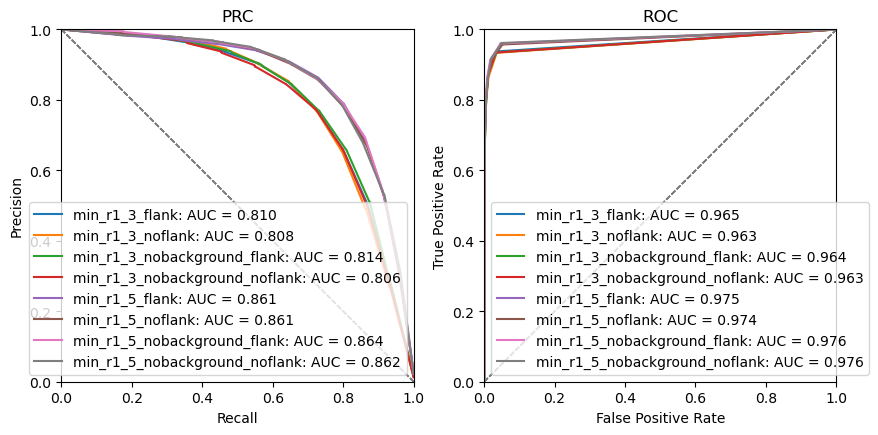

In [50]:
# plot for prc and roc
_, ax = plt.subplots(1, 2, figsize=(10, 5))

n_estimators = 10

for k, v in datas.items():
    print(f"\nprocessesing {k}...")

    # filter the data based on dictionary of boolean filters
    print("filtering data...")
    clf_df = filter_data(df, v)

    clf_df.loc[clf_df["label"] == "RMSK", "label"] = "OTHER"
    clf_df.loc[clf_df["label"] == "FLANK", "label"] = "OTHER"

    print("label counts: ")
    print(clf_df["label"].value_counts())

    # split into train and test sets
    print("splitting data into train and test sets...")
    sgkf = StratifiedGroupKFold(
        n_splits=4, shuffle=True, random_state=1
    )  # take first fold
    sgkf = sgkf.split(clf_df[features], clf_df["label"], groups=clf_df["cell_id"])
    train_inds, test_inds = next(sgkf)
    train = clf_df.iloc[train_inds]
    test = clf_df.iloc[test_inds]

    # define classifier
    clf = RandomForestClassifier(
        n_estimators=n_estimators, oob_score=True, n_jobs=10, random_state=1
    )

    # fit and evaluate model
    print("fitting and evaluating model...")
    prc, roc, fi = fit_evaluate(train, test, clf)

    # update plot
    print("plotting...")
    ax = plot_roc_prc(prc, roc, f"{k}_{i}", ax)

plt.show()

In [ ]:
# Feature Importance
sns.set(font_scale=1)
fig = sns.FacetGrid(fi, col="data", col_wrap=4, sharex=False, height=6, aspect=0.6)
fig.map_dataframe(
    sns.barplot,
    x="importance",
    y="feature",
)
sns.despine()

# Pick best prefiltering strategy and write output to file

In [24]:
print("filtering...")
clf_df = filter_data(df, datas["min_r1_5"])
clf_df.loc[clf_df["label"] == "RMSK", "label"] = "OTHER"
clf_df.loc[clf_df["label"] == "FLANK", "label"] = "OTHER"
clf_df["label_encoded"] = clf_df["label"].map({"KNRGL": 1, "OTHER": 0})
print("saving...")
clf_df.to_parquet("CommonBrain_prefiltered.pqt")

filtering...
removed 27876727/28877825 (96.53%) FLANK bins
removed 23744408/24274985 (97.81%) RMSK bins
removed 7611198/7698208 (98.87%) OTHER bins
removed 19725/58450 (33.75%) KNRGL bins
lost 3053/14584 (20.93%) covered knrgl
saving...


In [26]:
with open("CommonBrain_prefiltered_features.txt", "w") as file:
    for f in features:
        file.write(f + "\n")